# Imports

In [1]:
using DataFrames
using CSV
using MLJ
using DecisionTree: print_tree
using Plots
using StatsBase

include("../../lib.jl")

ENV["LINES"]=30;

In [2]:
mkdir("./Figures")

LoadError: IOError: mkdir: file already exists (EEXIST)

# Data

In [3]:
data = CSV.read("data.csv")

,Mean of the integrated profile,Standard deviation of the integrated profile
,Float64,Float64
1,140.562,55.6838
2,102.508,58.8824
3,103.016,39.3416
4,136.75,57.1784
5,88.7266,40.6722
6,93.5703,46.6981
7,119.484,48.7651
8,130.383,39.8441
9,107.25,52.6271


In [4]:
describe(data, cols=:)

,variable,mean,min,median,max
,Symbol,Float64,Real,Float64,Real
1,Mean of the integrated profile,111.08,5.8125,115.078,192.617
2,Standard deviation of the integrated profile,46.5495,24.772,46.9475,98.7789
3,Excess kurtosis of the integrated profile,0.477857,-1.87601,0.22324,8.06952
4,Skewness of the integrated profile,1.77028,-1.79189,0.19871,68.1016
5,Mean of the DM-SNR curve,12.6144,0.213211,2.80184,223.392
6,Standard deviation of the DM-SNR curve,26.3265,7.37043,18.4613,110.642
7,Excess kurtosis of the DM-SNR curve,8.30356,-3.13927,8.43351,34.5398
8,Skewness of the DM-SNR curve,104.858,-1.97698,83.0646,1191.0
9,target_class,0.0915745,0,0.0,1


Look at class labels to see if dataset is imbalanced

In [5]:
label_counts = countmap(data[:(target_class)])

Dict{Int64,Int64} with 2 entries:
  0 => 16259
  1 => 1639

In [6]:
collect(label_counts[i] / size(data)[1] for i in keys(label_counts))

2-element Array{Float64,1}:
 0.908425522404738
 0.09157447759526204

Get data ready for training

In [8]:
coerce!(data, :target_class=>Multiclass)
schema(data)

┌───────────────────────────────────────────────┬────────────────────────────────┬───────────────┐
│ _.names                                       │ _.types                        │ _.scitypes    │
├───────────────────────────────────────────────┼────────────────────────────────┼───────────────┤
│  Mean of the integrated profile               │ Float64                        │ Continuous    │
│  Standard deviation of the integrated profile │ Float64                        │ Continuous    │
│  Excess kurtosis of the integrated profile    │ Float64                        │ Continuous    │
│  Skewness of the integrated profile           │ Float64                        │ Continuous    │
│  Mean of the DM-SNR curve                     │ Float64                        │ Continuous    │
│  Standard deviation of the DM-SNR curve       │ Float64                        │ Continuous    │
│  Excess kurtosis of the DM-SNR curve          │ Float64                        │ Continuous    │
│  Skewnes

In [9]:
y, X = unpack(data, ==(:target_class), colname->true)

(CategoricalValue{Int64,UInt32}[0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 17898×8 DataFrame. Omitted printing of 7 columns
│ Row   │  Mean of the integrated profile │
│       │ Float64                         │
├───────┼─────────────────────────────────┤
│ 1     │ 140.562                         │
│ 2     │ 102.508                         │
│ 3     │ 103.016                         │
│ 4     │ 136.75                          │
│ 5     │ 88.7266                         │
│ 6     │ 93.5703                         │
│ 7     │ 119.484                         │
│ 8     │ 130.383                         │
│ 9     │ 107.25                          │
│ 10    │ 107.258                         │
⋮
│ 17888 │ 121.375                         │
│ 17889 │ 98.7266                         │
│ 17890 │ 126.625                         │
│ 17891 │ 143.672                         │
│ 17892 │ 118.484                         │
│ 17893 │ 96.0                            │
│ 17894 │ 136.43 

Partition train and test data accoring to class labels

In [49]:
# data to use when trying to fit a single validation set
train, test = partition(eachindex(y), 0.7, shuffle=true, rng=123, stratify=values(data[:target_class])) # gives 70:30 split

([2859, 3242, 436, 12919, 3279, 17651, 16341, 14975, 16060, 730  …  805, 13608, 9896, 11042, 13883, 3467, 112, 9612, 2792, 261], [1078, 16815, 4553, 12452, 10187, 17806, 8156, 16807, 2688, 1554  …  4126, 15656, 16102, 15077, 13659, 13276, 13241, 8204, 5417, 415])

In [50]:
train_counts = countmap(data[train,:target_class])
collect(train_counts[i] / size(train)[1] for i in keys(train_counts))

2-element Array{Float64,1}:
 0.9084450830140486
 0.09155491698595147

In [51]:
test_counts = countmap(data[test,:target_class])
collect(test_counts[i] / size(test)[1] for i in keys(test_counts))

2-element Array{Float64,1}:
 0.9083798882681564
 0.09162011173184358

# Five Learning Algorithms

* Decision trees with some form of pruning
* Neural networks
* Boosting
* Support Vector Machines
* k-nearest neighbors


##### Testing
* Implement the algorithms
* Design two *interesting* classification problems. For the purposes of this assignment, a classification problem is just a set of training examples and a set of test examples.

In [52]:
models(matching(X,y))

43-element Array{NamedTuple{(:name, :package_name, :is_supervised, :docstring, :hyperparameter_ranges, :hyperparameter_types, :hyperparameters, :implemented_methods, :is_pure_julia, :is_wrapper, :load_path, :package_license, :package_url, :package_uuid, :prediction_type, :supports_online, :supports_weights, :input_scitype, :target_scitype, :output_scitype),T} where T<:Tuple,1}:
 (name = AdaBoostClassifier, package_name = ScikitLearn, ... )
 (name = AdaBoostStumpClassifier, package_name = DecisionTree, ... )
 (name = BaggingClassifier, package_name = ScikitLearn, ... )
 (name = BayesianLDA, package_name = MultivariateStats, ... )
 (name = BayesianLDA, package_name = ScikitLearn, ... )
 (name = BayesianQDA, package_name = ScikitLearn, ... )
 (name = BayesianSubspaceLDA, package_name = MultivariateStats, ... )
 (name = ConstantClassifier, package_name = MLJModels, ... )
 (name = DecisionTreeClassifier, package_name = DecisionTree, ... )
 (name = DeterministicConstantClassifier, package_na

In [53]:
@load DecisionTreeClassifier verbosity=2

┌ Info: Model code for DecisionTreeClassifier already loaded
└ @ MLJModels /home/andrew/.julia/packages/MLJModels/5DFoi/src/loading.jl:54


DecisionTreeClassifier(
    max_depth = -1,
    min_samples_leaf = 1,
    min_samples_split = 2,
    min_purity_increase = 0.0,
    n_subfeatures = 0,
    post_prune = false,
    merge_purity_threshold = 1.0,
    pdf_smoothing = 0.0,
    display_depth = 5) @181

## Decision trees
* Be sure to use some form of pruning. 
* You are not required to use information gain (for example, there is something called the GINI index that is sometimes used) to split attributes, but you should describe whatever it is that you do use.

1. https://alan-turing-institute.github.io/MLJ.jl/dev/transformers/#MLJModels.UnivariateDiscretizer
1. https://alan-turing-institute.github.io/MLJ.jl/dev/getting_started/#Getting-Started-1

### No post-pruning

In [54]:
dt = DecisionTreeClassifier(post_prune=false, display_depth=8)

DecisionTreeClassifier(
    max_depth = -1,
    min_samples_leaf = 1,
    min_samples_split = 2,
    min_purity_increase = 0.0,
    n_subfeatures = 0,
    post_prune = false,
    merge_purity_threshold = 1.0,
    pdf_smoothing = 0.0,
    display_depth = 8) @418

In [55]:
Tree = machine(dt, X, y)

Machine{DecisionTreeClassifier} @049 trained 0 times.
  args: 
    1:	Source @855 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @115 ⏎ `AbstractArray{Multiclass{2},1}`


In [56]:
fit!(Tree, rows=train, verbosity=2)

┌ Info: Training Machine{DecisionTreeClassifier} @049.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/cJmIS/src/machines.jl:322


Feature 3, Threshold 1.0845743415
L-> Feature 3, Threshold 0.3457475635
    L-> Feature 3, Threshold 0.163776564
        L-> Feature 3, Threshold -0.09493500099999999
            L-> 1 : 1594/1594
            R-> Feature 3, Threshold -0.0948241945
                L-> 2 : 1/1
                R-> Feature 1, Threshold 127.2421875
                    L-> Feature 3, Threshold -0.018585328499999998
                        L-> Feature 3, Threshold -0.0189379425
                            L-> 1 : 330/330
                            R-> 2 : 1/1
                        R-> 1 : 1884/1884
                    R-> Feature 1, Threshold 127.59765625
                        L-> Feature 1, Threshold 127.56640625
                            L-> 
                            R-> 
                        R-> Feature 3, Threshold 0.088706859
                            L-> 1 : 1147/1147
                            R-> 
        R-> Feature 2, Threshold 45.557603549999996
            L-> Feature 2, Threshold 

Machine{DecisionTreeClassifier} @049 trained 1 time.
  args: 
    1:	Source @855 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @115 ⏎ `AbstractArray{Multiclass{2},1}`


In [57]:
dt_acc = evaluate!(Tree, resampling=CV(shuffle=true), measure=[cross_entropy, acc], verbosity=1)

Evaluating over 6 folds: 100%[=========================] Time: 0:00:00


┌───────────────┬───────────────┬────────────────────────────────────────────┐
│ _.measure     │ _.measurement │ _.per_fold                                 │
├───────────────┼───────────────┼────────────────────────────────────────────┤
│ cross_entropy │ 1.2           │ [1.04, 1.35, 1.24, 1.21, 1.14, 1.24]       │
│ acc           │ 0.967         │ [0.971, 0.962, 0.965, 0.966, 0.968, 0.965] │
└───────────────┴───────────────┴────────────────────────────────────────────┘
_.per_observation = [[[2.22e-16, 2.22e-16, ..., 2.22e-16], [2.22e-16, 2.22e-16, ..., 2.22e-16], [2.22e-16, 2.22e-16, ..., 2.22e-16], [2.22e-16, 2.22e-16, ..., 2.22e-16], [2.22e-16, 2.22e-16, ..., 2.22e-16], [2.22e-16, 2.22e-16, ..., 2.22e-16]], missing]


In [58]:
fitted_params(Tree) 
# print_tree(Tree.fitresult[1])

(tree = Decision Tree
Leaves: 324
Depth:  20,
 encoding = Dict{CategoricalValue{Int64,UInt32},UInt32}(0 => 0x00000001,1 => 0x00000002),)

In [59]:
report(Tree)

(classes_seen = CategoricalValue{Int64,UInt32}[0, 1],
 print_tree = TreePrinter object (call with display depth),)

### Using Post-pruning

In [21]:
dt2 = DecisionTreeClassifier(post_prune=true)

DecisionTreeClassifier(
    max_depth = -1,
    min_samples_leaf = 1,
    min_samples_split = 2,
    min_purity_increase = 0.0,
    n_subfeatures = 0,
    post_prune = true,
    merge_purity_threshold = 1.0,
    pdf_smoothing = 0.0,
    display_depth = 5) @822

In [22]:
Tree2 = machine(dt2, X, y)

Machine{DecisionTreeClassifier} @697 trained 0 times.
  args: 
    1:	Source @999 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @976 ⏎ `AbstractArray{Multiclass{2},1}`


In [23]:
fit!(Tree2, rows=train, verbosity=2, force=true)

┌ Info: Training Machine{DecisionTreeClassifier} @697.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/cJmIS/src/machines.jl:322


Feature 3, Threshold 1.125419075
L-> Feature 3, Threshold 0.3315821845
    L-> Feature 3, Threshold 0.08878459899999999
        L-> Feature 1, Threshold 127.59375
            L-> Feature 1, Threshold 127.56640625
                L-> 1 : 1545/1545
                R-> 
            R-> 1 : 2525/2525
        R-> Feature 2, Threshold 45.713650945
            L-> Feature 6, Threshold 28.437492499999998
                L-> 
                R-> 
            R-> Feature 3, Threshold 0.089089753
                L-> 2 : 1/1
                R-> 
    R-> Feature 6, Threshold 26.103903135000003
        L-> Feature 6, Threshold 15.81663735
            L-> Feature 5, Threshold 0.959866221
                L-> 
                R-> 
            R-> Feature 3, Threshold 0.7677057494999999
                L-> 
                R-> 
        R-> Feature 3, Threshold 0.9116480495
            L-> Feature 2, Threshold 42.575829035
                L-> 
                R-> 
            R-> Feature 2, Threshold 36.

Machine{DecisionTreeClassifier} @697 trained 1 time.
  args: 
    1:	Source @999 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @976 ⏎ `AbstractArray{Multiclass{2},1}`


In [24]:
dt_acc = evaluate!(Tree2, resampling=CV(shuffle=true), measure=[cross_entropy, acc], verbosity=1)

Evaluating over 6 folds: 100%[=========================] Time: 0:00:00


┌───────────────┬───────────────┬───────────────────────────────────────────┐
│ _.measure     │ _.measurement │ _.per_fold                                │
├───────────────┼───────────────┼───────────────────────────────────────────┤
│ cross_entropy │ 1.13          │ [0.906, 1.28, 1.06, 1.17, 1.1, 1.27]      │
│ acc           │ 0.969         │ [0.975, 0.964, 0.97, 0.967, 0.969, 0.965] │
└───────────────┴───────────────┴───────────────────────────────────────────┘
_.per_observation = [[[2.22e-16, 2.22e-16, ..., 2.22e-16], [2.22e-16, 2.22e-16, ..., 2.22e-16], [2.22e-16, 2.22e-16, ..., 2.22e-16], [36.0, 2.22e-16, ..., 2.22e-16], [2.22e-16, 2.22e-16, ..., 2.22e-16], [36.0, 2.22e-16, ..., 2.22e-16]], missing]


In [25]:
# evaluate!(Tree2, resampling=CV(shuffle=true), measure=[tnr,tpr,fnr,fpr], verbosity=1, operation=predict_mode)

In [26]:
fitted_params(Tree2) 
# print_tree(Tree.fitresult[1])

(tree = Decision Tree
Leaves: 317
Depth:  29,
 encoding = Dict{CategoricalValue{Int64,UInt32},UInt32}(0 => 0x00000001,1 => 0x00000002),)

In [27]:
report(Tree2)

(classes_seen = CategoricalValue{Int64,UInt32}[0, 1],
 print_tree = TreePrinter object (call with display depth),)

### GridSearch / RandomSearch

In [28]:
r = range(dt2, :merge_purity_threshold, lower=0, upper=1, scale=:linear)
curve = learning_curve(Tree2, 
                        range=r, 
#                         resampling=Holdout(fraction_train=0.7), 
                        resampling=CV(), 
                        measure=cross_entropy, 
                        acceleration=CPUThreads())

┌ Info: Training Machine{ProbabilisticTunedModel{Grid,…}} @051.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/cJmIS/src/machines.jl:322
┌ Info: Attempting to evaluate 101 models.
└ @ MLJTuning /home/andrew/.julia/packages/MLJTuning/nuvTc/src/tuned_models.jl:501
Evaluating over 101 metamodels: 100%[=========================] Time: 0:03:40


(parameter_name = "merge_purity_threshold",
 parameter_scale = :none,
 parameter_values = [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09  …  0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1.0],
 measurements = [0.31734618337388115, 0.31734618337388115, 0.31734618337388115, 0.31734618337388115, 0.31734618337388115, 0.31734618337388115, 0.31734618337388115, 0.31734618337388115, 0.31734618337388115, 0.31734618337388115  …  1.052846031257589, 1.061957280663215, 1.0805719658850375, 1.0878862555230084, 1.1175505997516766, 1.1335571841402483, 1.1530839889656255, 1.1558495503041937, 1.1380860083490822, 1.1438593767470413],)

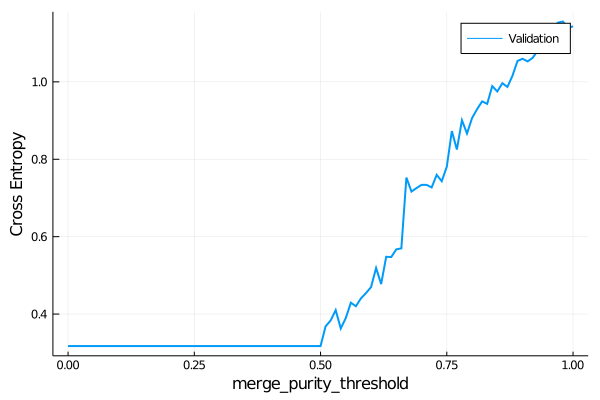

In [29]:
plot(curve.parameter_values,
     curve.measurements,
     xlab=curve.parameter_name,
     ylab="Cross Entropy",
     label="Validation", lw=2)
# plot!(Net2.report.training_losses, label="Training", lw=2)

In [30]:
a = round(minimum(curve.measurements), digits=5)

0.31735

In [60]:
curve.parameter_values[argmin(curve.measurements)]

0.0

In [76]:
param1 = :merge_purity_threshold

r1 = range(dt2, param1, lower=0, upper=0.5, scale=:linear)

MLJBase.NumericRange(Float64, :merge_purity_threshold, ... )

In [77]:
self_tuning_dt_model = TunedModel(model=dt2,
                                    tuning=Grid(goal=100),
                                    resampling=CV(), 
                                    measure=cross_entropy,
                                    acceleration=CPUThreads(),
                                    range=[r1])

ProbabilisticTunedModel(
    model = DecisionTreeClassifier(
            max_depth = -1,
            min_samples_leaf = 1,
            min_samples_split = 2,
            min_purity_increase = 0.0,
            n_subfeatures = 0,
            post_prune = true,
            merge_purity_threshold = 1.0,
            pdf_smoothing = 0.0,
            display_depth = 5),
    tuning = Grid(
            goal = 100,
            resolution = 10,
            shuffle = true,
            rng = Random._GLOBAL_RNG()),
    resampling = CV(
            nfolds = 6,
            shuffle = false,
            rng = Random._GLOBAL_RNG()),
    measure = cross_entropy(
            eps = 2.220446049250313e-16),
    weights = nothing,
    operation = MLJModelInterface.predict,
    range = MLJBase.NumericRange{Float64,MLJBase.Bounded,Symbol}[NumericRange{Float64,…} @140],
    train_best = true,
    repeats = 1,
    n = nothing,
    acceleration = CPUThreads{Int64}(1),
    acceleration_resampling = CPU1{Nothing}(not

In [78]:
self_tuning_dt = machine(self_tuning_dt_model, X, y)

Machine{ProbabilisticTunedModel{Grid,…}} @151 trained 0 times.
  args: 
    1:	Source @446 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @328 ⏎ `AbstractArray{Multiclass{2},1}`


In [79]:
z = fit!(self_tuning_dt, rows=train)

┌ Info: Training Machine{ProbabilisticTunedModel{Grid,…}} @151.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/cJmIS/src/machines.jl:322
┌ Info: Attempting to evaluate 100 models.
└ @ MLJTuning /home/andrew/.julia/packages/MLJTuning/nuvTc/src/tuned_models.jl:501
Evaluating over 100 metamodels: 100%[=========================] Time: 0:02:51


Machine{ProbabilisticTunedModel{Grid,…}} @151 trained 1 time.
  args: 
    1:	Source @446 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @328 ⏎ `AbstractArray{Multiclass{2},1}`


In [80]:
best = fitted_params(self_tuning_dt)
best

(best_model = DecisionTreeClassifier @688,
 best_fitted_params = (tree = Decision Leaf
Majority: 1
Samples:  12528,
                       encoding = Dict{CategoricalValue{Int64,UInt32},UInt32}(0 => 0x00000001,1 => 0x00000002),),)

In [81]:
best.best_model

DecisionTreeClassifier(
    max_depth = -1,
    min_samples_leaf = 1,
    min_samples_split = 2,
    min_purity_increase = 0.0,
    n_subfeatures = 0,
    post_prune = true,
    merge_purity_threshold = 0.09595959595959595,
    pdf_smoothing = 0.0,
    display_depth = 5) @688

In [82]:
best_loss = round(z.report.best_result.measurement[1],digits=5)

0.30623

In [83]:
best_mpt = round(best.best_model.merge_purity_threshold,digits=5)
# best_mpt = 0.5

0.09596

In [65]:
fn = "Figures/LearningCurve_DT_merge_purity_thresh:$(best_mpt)_loss:$(best_loss)"
png(replace(fn,'.' => ','))

### Learning Curve

In [84]:
dt = DecisionTreeClassifier(merge_purity_threshold=best_mpt)
data_schedule, training_losses, valid_losses = learn_curve(dt, X[train,:], y[train], acc, step=50)

(d, train_metric, valid_metric) = (10, 1.0, 0.8918595371109338)
(d, train_metric, valid_metric) = (60, 1.0, 0.9577015163607342)
(d, train_metric, valid_metric) = (110, 1.0, 0.9692737430167597)
(d, train_metric, valid_metric) = (160, 1.0, 0.9505187549880287)
(d, train_metric, valid_metric) = (210, 1.0, 0.9704708699122107)
(d, train_metric, valid_metric) = (260, 1.0, 0.9724660814046289)
(d, train_metric, valid_metric) = (310, 1.0, 0.9676775738228253)
(d, train_metric, valid_metric) = (360, 1.0, 0.9772545889864326)
(d, train_metric, valid_metric) = (410, 1.0, 0.9720670391061452)
(d, train_metric, valid_metric) = (460, 1.0, 0.9712689545091779)
(d, train_metric, valid_metric) = (510, 1.0, 0.9672785315243416)
(d, train_metric, valid_metric) = (560, 1.0, 0.9652833200319234)
(d, train_metric, valid_metric) = (610, 1.0, 0.9768555466879489)
(d, train_metric, valid_metric) = (660, 1.0, 0.9760574620909817)
(d, train_metric, valid_metric) = (710, 1.0, 0.9696727853152434)
(d, train_metric, valid_met

(d, train_metric, valid_metric) = (6260, 1.0, 0.9680766161213089)
(d, train_metric, valid_metric) = (6310, 1.0, 0.9676775738228253)
(d, train_metric, valid_metric) = (6360, 1.0, 0.9672785315243416)
(d, train_metric, valid_metric) = (6410, 1.0, 0.9684756584197926)
(d, train_metric, valid_metric) = (6460, 1.0, 0.9676775738228253)
(d, train_metric, valid_metric) = (6510, 1.0, 0.966879489225858)
(d, train_metric, valid_metric) = (6560, 1.0, 0.9704708699122107)
(d, train_metric, valid_metric) = (6610, 1.0, 0.9712689545091779)
(d, train_metric, valid_metric) = (6660, 1.0, 0.9704708699122107)
(d, train_metric, valid_metric) = (6710, 1.0, 0.9680766161213089)
(d, train_metric, valid_metric) = (6760, 1.0, 0.9640861931364725)
(d, train_metric, valid_metric) = (6810, 1.0, 0.9648842777334398)
(d, train_metric, valid_metric) = (6860, 1.0, 0.9708699122106943)
(d, train_metric, valid_metric) = (6910, 1.0, 0.9664804469273743)
(d, train_metric, valid_metric) = (6960, 1.0, 0.966879489225858)
(d, train_me

(10:50:10010, Any[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], Any[0.8918595371109338, 0.9577015163607342, 0.9692737430167597, 0.9505187549880287, 0.9704708699122107, 0.9724660814046289, 0.9676775738228253, 0.9772545889864326, 0.9720670391061452, 0.9712689545091779  …  0.9680766161213089, 0.9680766161213089, 0.9692737430167597, 0.9708699122106943, 0.9712689545091779, 0.9708699122106943, 0.9684756584197926, 0.970071827613727, 0.9720670391061452, 0.9728651237031125])

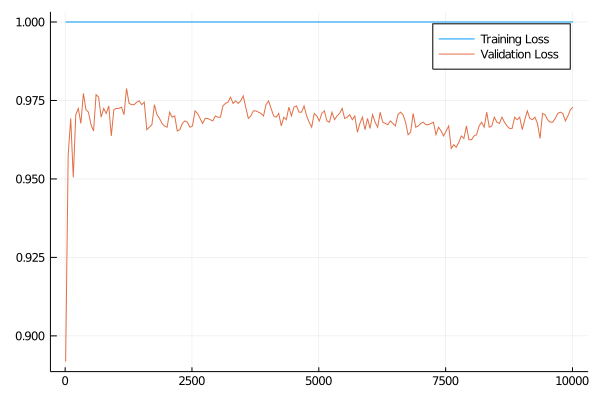

In [85]:
plot(data_schedule, training_losses, label="Training Loss")
plot!(data_schedule, valid_losses, label="Validation Loss")

# Final Results

In [86]:
final_dt = dt

DecisionTreeClassifier(
    max_depth = -1,
    min_samples_leaf = 1,
    min_samples_split = 2,
    min_purity_increase = 0.0,
    n_subfeatures = 0,
    post_prune = false,
    merge_purity_threshold = 0.09596,
    pdf_smoothing = 0.0,
    display_depth = 5) @959

In [87]:
Final_Tree = machine(final_dt, X, y)

Machine{DecisionTreeClassifier} @587 trained 0 times.
  args: 
    1:	Source @735 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @377 ⏎ `AbstractArray{Multiclass{2},1}`


In [88]:
fit!(Final_Tree, rows=train, verbosity=2)

┌ Info: Training Machine{DecisionTreeClassifier} @587.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/cJmIS/src/machines.jl:322


Feature 3, Threshold 1.0845743415
L-> Feature 3, Threshold 0.3457475635
    L-> Feature 3, Threshold 0.163776564
        L-> Feature 3, Threshold -0.09493500099999999
            L-> 1 : 1594/1594
            R-> Feature 3, Threshold -0.0948241945
                L-> 2 : 1/1
                R-> 
        R-> Feature 2, Threshold 45.557603549999996
            L-> Feature 2, Threshold 45.54981163
                L-> 
                R-> 2 : 1/1
            R-> Feature 3, Threshold 0.1639058065
                L-> 2 : 1/1
                R-> 
    R-> Feature 6, Threshold 27.994632285
        L-> Feature 3, Threshold 0.7677057494999999
            L-> Feature 2, Threshold 37.455441855000004
                L-> 1 : 351/351
                R-> 
            R-> Feature 2, Threshold 42.859770995000005
                L-> 
                R-> 
        R-> Feature 3, Threshold 0.817397867
            L-> Feature 7, Threshold 3.1218967575
                L-> 
                R-> 
            R-> 

Machine{DecisionTreeClassifier} @587 trained 1 time.
  args: 
    1:	Source @735 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @377 ⏎ `AbstractArray{Multiclass{2},1}`


In [89]:
ŷ2 = MLJ.predict(Final_Tree, X[test,:]);

In [90]:
cross_entropy(ŷ2, y[test]) |> mean

1.2081671527078377

In [91]:
acc(ŷ2, y[test])

0.9664804469273743

In [92]:
confusion_matrix(mode.(ŷ2), y[test])

┌ Warning: The classes are un-ordered,
│ using: negative='0' and positive='1'.
│ To suppress this warning, consider coercing to OrderedFactor.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/cJmIS/src/measures/confusion_matrix.jl:83


              ┌───────────────────────────┐
              │       Ground Truth        │
┌─────────────┼─────────────┬─────────────┤
│  Predicted  │      0      │      1      │
├─────────────┼─────────────┼─────────────┤
│      0      │    4788     │     90      │
├─────────────┼─────────────┼─────────────┤
│      1      │     90      │     402     │
└─────────────┴─────────────┴─────────────┘
